In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings('ignore') 

In [2]:
i3e_data=pd.read_csv('/Users/han/Desktop/CASA/Dissertation/Code/Dissertation/2016.csv')
print(i3e_data.describe())

               М1, t          М2, t          ΔМ, t         Т1, °C  \
count  164792.000000  164792.000000  164792.000000  164792.000000   
mean      137.630041     133.575492       4.054543      76.274687   
std       111.781591     111.300147       7.543280      11.042464   
min         0.800000       0.010000     -25.600000      40.010000   
25%        75.080000      71.470000      -0.190000      66.880000   
50%       113.040000     107.590000       2.000000      74.900000   
75%       157.250000     152.680000       7.000000      85.220000   
max      1675.390000    1659.390000     514.310000     116.990000   

              Т2, °C         ΔТ, °C        Q, Gcal           USPD  \
count  164792.000000  164792.000000  164792.000000  164792.000000   
mean       50.367019      25.907669       3.385007    1124.833505   
std         5.812095       8.006409       2.535829     807.946417   
min         6.380000       2.050000       0.010000       1.000000   
25%        46.310000      20.3100

In [3]:
type_Date=i3e_data['Date'].dtypes
type_Date

dtype('O')

In [4]:
import datetime
from datetime import datetime

dt = i3e_data["Date"]

# dt = datetime.strptime(dt, '%Y-%m-%d %H:%M:%S')
dt = dt.apply(lambda x:datetime.strptime(x, '%Y/%m/%d'))

i3e_data["year_now"] = dt.map(lambda x: x.year)
i3e_data['age of building'] = i3e_data['year_now'] - i3e_data['year of construction']
i3e_data.drop(columns=['year_now', 'Date', 'YYYYMM', 'USPD', 'type'], inplace=True)
i3e_data.head()

,"М1, t","М2, t","ΔМ, t","Т1, °C","Т2, °C","ΔТ, °C","Q, Gcal",registrated,scheme,area,floors,walls material,year of construction,area of building,"temp,˚C",age of building
0,102.51,92.05,10.46,81.99,53.36,28.63,2.94,Heating + Hot water,opened,2707.4,5,panel,1983,4401.0,-17.782121,33
1,124.86,125.29,-0.43,82.58,50.24,32.34,4.05,Heating + Hot water,closed,3358.4,5,brick,1974,3610.4,-17.782121,42
2,127.31,128.51,-1.20,83.26,51.72,31.55,4.02,Heating + Hot water,closed,3153.5,5,brick,1975,3150.2,-17.782121,41
3,86.36,81.61,4.75,92.55,54.82,37.73,3.26,Heating + Hot water,opened,2646.5,5,panel,1982,2932.7,-17.782121,34
4,170.81,168.74,2.07,83.29,59.70,23.59,4.04,Heating + Hot water,closed,3187.5,5,brick,1976,3456.2,-17.782121,40


|serial|name|description|type|
|:--:|:--:|:--|:--:|
| (A)| Date |date in Windows format.|Date
| (B)| M1, t |mass of the input water (heat carrier) per day.|Ratio
| (C)| М2, t |mass of the output water. If the residential building has the open heating system (hot water is flowed from the heating system), (C) less than (B).|Ratio
| (D)| ΔМ, t |difference in volumes (C)-(B). For buildings with the opened heating system this is the data for analysis. In closed system it is the technological parameter allows observation for equipment.|Ratio
| (E)| Т1, °C |average temperature of the heating carrier in the input of the heating system. It is the independent variable from home characteristics.|Interval
| (F)| Т2, °C |average temperature of the heating carrier in the output. It is the dependent variable both from (E) and heating consumption at building.|Interval
| (G)| ΔТ, °C |temperature difference, (F)-(E).|Interval
| (H)| Q, Gcal |amount of the consumed heating in Gcal. It is calculated by formula.|Ratio
| (I)| USPD |ID of the heating meter. Some residential buildings have many heating meters.|Nominal
| (J)| YYYYMM |date in the format year-month YYYYMM.|Date
| (K)| registrated |what is registrated, heating or heating plus hot water.|Nominal
| (L)| scheme |type of the heating system (opened or closed).|Nominal
| (M)| type |code system-load (4 digits). First digit 1 is opened system, 2 is closed system. The second digit 0 is heating, 1 is heating and hot water supply. The third and fourth digits is floors amount (01, 02, 03, ..., 17).|Nominal
| (N)| area |area of building that heating meter is served.|Ratio
| (O)| floors |amount of building floors. |Ordinal
| (P)| walls material |walls material.|Nominal
| (Q)| year of construction |year of building construction.|Date
| (R)| area of building |total area of building.|Ratio
| (S)| temp,˚C |outdoor temperature.|Interval

In [5]:
c = LabelEncoder().fit_transform(i3e_data['scheme'])
df_scheme = pd.DataFrame(c)
df_scheme.columns=['scheme']

c = LabelEncoder().fit_transform(i3e_data['floors'])
df_floors = pd.DataFrame(c)
df_floors.columns=['floors']

c = LabelEncoder().fit_transform(i3e_data['walls material'])
df_wallsMaterial = pd.DataFrame(c)
df_wallsMaterial.columns=['walls materials']

c = LabelEncoder().fit_transform(i3e_data['registrated'])
df_registered = pd.DataFrame(c)
df_registered.columns=['registrated']

df_x=np.concatenate([df_scheme,df_wallsMaterial,df_registered,df_floors],axis=-1)

df_Label =pd.DataFrame(df_x)
data_Label = i3e_data.drop(columns=['scheme', 'registrated', 'floors', 'walls material'])
data_Label


,"М1, t","М2, t","ΔМ, t","Т1, °C","Т2, °C","ΔТ, °C","Q, Gcal",area,year of construction,area of building,"temp,˚C",age of building
0,102.51,92.05,10.46,81.99,53.36,28.63,2.94,2707.4,1983,4401.00,-17.782121,33
1,124.86,125.29,-0.43,82.58,50.24,32.34,4.05,3358.4,1974,3610.40,-17.782121,42
2,127.31,128.51,-1.20,83.26,51.72,31.55,4.02,3153.5,1975,3150.20,-17.782121,41
3,86.36,81.61,4.75,92.55,54.82,37.73,3.26,2646.5,1982,2932.70,-17.782121,34
4,170.81,168.74,2.07,83.29,59.70,23.59,4.04,3187.5,1976,3456.20,-17.782121,40
...,...,...,...,...,...,...,...,...,...,...,...,...
164787,102.46,86.99,15.47,77.50,52.95,24.55,2.51,1886.0,1979,13548.30,-8.144842,37
164788,79.47,71.58,7.89,77.56,48.82,28.74,2.29,2139.1,1964,4262.06,-8.144842,52
164789,274.49,272.79,1.69,77.89,49.34,28.55,7.86,6609.2,1999,12626.10,-8.144842,17
164790,436.13,437.33,-1.20,66.52,49.35,17.17,7.50,6447.4,1988,7249.70,-8.144842,28


In [34]:
for item in df_Label.columns:
    data_Label[str(item)]=df_Label[item].values

data_Label.rename(columns={'0':'scheme', '1':'walls material', '2':'registered', '3':'floors'}, inplace=True)
print (data_Label.describe())

               М1, t          М2, t          ΔМ, t         Т1, °C  \
count  164792.000000  164792.000000  164792.000000  164792.000000   
mean      137.630041     133.575492       4.054543      76.274687   
std       111.781591     111.300147       7.543280      11.042464   
min         0.800000       0.010000     -25.600000      40.010000   
25%        75.080000      71.470000      -0.190000      66.880000   
50%       113.040000     107.590000       2.000000      74.900000   
75%       157.250000     152.680000       7.000000      85.220000   
max      1675.390000    1659.390000     514.310000     116.990000   

              Т2, °C         ΔТ, °C        Q, Gcal           area  \
count  164792.000000  164792.000000  164792.000000  164792.000000   
mean       50.367019      25.907669       3.385007    3476.709410   
std         5.812095       8.006409       2.535829    2268.625664   
min         6.380000       2.050000       0.010000     169.400000   
25%        46.310000      20.3100

In [35]:
from sklearn.cluster import KMeans
# 取出这三类数据
data_k = data_Label[['ΔМ, t','ΔТ, °C','Q, Gcal']]


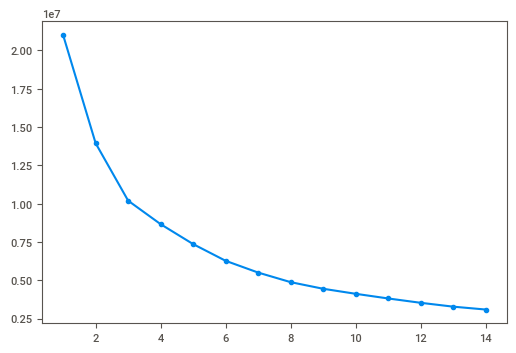

In [36]:
# K值查找
distor =[]
for i in range(1,15):
    km = KMeans(n_clusters =i)
    km.fit(data_k)
    distor.append(km.inertia_)
plt.plot(range(1,15),distor,marker='o')
plt.show()

In [37]:
# kmeans聚类训练
mod = KMeans(n_clusters=7,random_state=255)
y_pre = mod.fit_predict(data_k)
# 聚类的数目
r1 = pd.Series(mod.labels_).value_counts()
# 聚类的3个质心
r2 = pd.DataFrame(mod.cluster_centers_)
# 将获取到的聚类的数目以及获取的质心合并
r = pd.concat([r1,r2],axis = 1)
r.columns = ["count","ΔМ, t","ΔТ, °C","Q, Gcal"]
data_Label["kmeans_class"] = y_pre
display(r)

,count,"ΔМ, t","ΔТ, °C","Q, Gcal"
0,51883,0.718106,25.697179,3.087629
1,24012,10.689818,20.920717,2.974167
2,33299,0.422047,15.885277,2.396089
3,19826,10.183946,32.620395,4.583741
4,16,295.623750,20.915625,4.220000
5,32012,1.246942,36.330669,4.062255
6,3744,30.555520,25.517184,6.829354


In [38]:
# 删除异常值
data_k = data_k[~(data_k['ΔМ, t'].isin([5173.2]) | data_k['ΔТ, °C'].isin([25.22]))]  


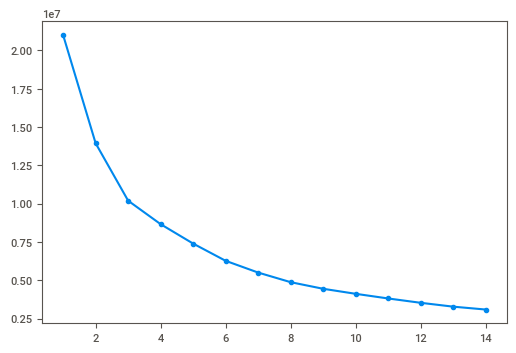

In [39]:
# K值查找
distor =[]
for i in range(1,15):
    km = KMeans(n_clusters =i)
    km.fit(data_k)
    distor.append(km.inertia_)
plt.plot(range(1,15),distor,marker='o')
plt.show()

In [40]:
# kmeans聚类训练
mod = KMeans(n_clusters=6,random_state=255)
y_pre = mod.fit_predict(data_k)
# 聚类的数目
r1 = pd.Series(mod.labels_).value_counts()
# 聚类的质心
r2 = pd.DataFrame(mod.cluster_centers_)
# 将获取到的聚类的数目以及获取的质心合并
r = pd.concat([r1,r2],axis = 1)
r.columns = ["count","ΔМ, t","ΔТ, °C","Q, Gcal"]
data_k["kmeans_class"] = y_pre
display(r)

,count,"ΔМ, t","ΔТ, °C","Q, Gcal"
0,36156,0.846967,15.992364,2.409375
1,41394,3.516974,36.118562,4.185044
2,5206,27.442788,26.677452,6.738928
3,29908,10.610113,23.346835,3.223425
4,16,295.623750,20.915625,4.220000
5,52046,0.503896,26.026910,3.179107


In [13]:
X = data_Label.drop(columns=['Q, Gcal'])
y = data_Label['Q, Gcal']

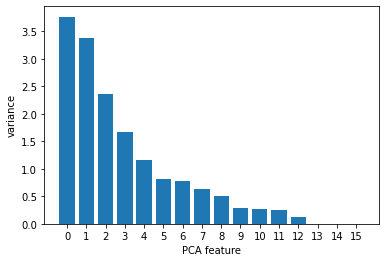

In [14]:
X_pca = X
Y_pca = y
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca, Y_pca, test_size=0.3)

# Create scaler: scaler
scaler = StandardScaler()
# Create a PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, pca)
# Fit the pipeline to 'samples'
pipeline.fit(X_pca)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

In [15]:
pca = PCA(n_components=6)
X_pca_new= pd.DataFrame(pca.fit_transform(X_pca))
X_pca_new

,0,1,2,3,4,5
0,-2730.441343,-493.908906,-14.082865,-1.896590,-14.541423,8.859325
1,-3450.051344,235.844879,-14.068311,8.522730,-10.449550,-6.304696
2,-3928.792867,79.766183,1.075977,7.038780,-12.097854,-6.776351
3,-4197.322975,-404.994858,-32.142650,2.636015,-24.637077,2.158963
4,-3620.670065,85.595807,59.084697,6.282211,-11.640162,-2.432539
...,...,...,...,...,...,...
164787,6284.532835,-2247.297542,45.337063,5.116964,1.304532,14.878148
164788,-2927.008035,-1045.832650,-12.323134,16.311837,5.864545,2.997467
164789,5852.007800,2552.251523,22.826701,-17.170903,-10.952469,-1.557796
164790,488.322008,2955.897487,253.634040,-10.636859,1.809740,-5.690164


In [16]:
import sweetviz as sv
my_report = sv.analyze(data_Label)
my_report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [17]:
from collections import Counter
print(Counter(data_Label['walls material']))

Counter({1: 84353, 3: 76884, 0: 1972, 4: 998, 2: 585})


In [18]:
'''from imblearn.over_sampling import RandomOverSampler  # 随机重复采样
from imblearn.over_sampling import SMOTE  # 选取少数类样本插值采样
X_smo = data_Label.drop(columns=['walls material'])
y_smo = data_Label['walls material']
smo = SMOTE(random_state=42)
X_smo, y_smo = smo.fit_resample(X_smo, y_smo.astype('int'))

print(Counter(y_smo))
y_smo
'''

"from imblearn.over_sampling import RandomOverSampler  # 随机重复采样\nfrom imblearn.over_sampling import SMOTE  # 选取少数类样本插值采样\nX_smo = data_Label.drop(columns=['walls material'])\ny_smo = data_Label['walls material']\nsmo = SMOTE(random_state=42)\nX_smo, y_smo = smo.fit_resample(X_smo, y_smo.astype('int'))\n\nprint(Counter(y_smo))\ny_smo\n"

In [19]:
data = pd.concat([X_smo, y_smo],axis=1)
data.head()

NameError: name 'X_smo' is not defined

In [ ]:
import sweetviz as sv
my_report = sv.analyze(data)
my_report.show_html()

In [20]:
X = data_Label.drop(columns=['М2, t', 'Q, Gcal', 'ΔМ, t', 'Т2, °C', 'ΔТ, °C', 'year of construction'])
y = data_Label['Q, Gcal']
X.head()

,"М1, t","Т1, °C",area,area of building,"temp,˚C",age of building,scheme,walls material,registered,floors,kmeans_class
0,102.51,81.99,2707.4,4401.0,-17.782121,33,1,3,1,4,3
1,124.86,82.58,3358.4,3610.4,-17.782121,42,0,1,1,4,5
2,127.31,83.26,3153.5,3150.2,-17.782121,41,0,1,1,4,5
3,86.36,92.55,2646.5,2932.7,-17.782121,34,1,3,1,4,5
4,170.81,83.29,3187.5,3456.2,-17.782121,40,0,1,1,4,0


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_pca_new, Y_pca, test_size=0.3, random_state=42)

In [22]:
import xgboost as xgb

gbm_param_grid = {
    'colsample_bytree': [0.5],
    'n_estimators': [500],
    'max_depth': [5]
}

gbm = xgb.XGBRegressor(objective ='reg:squarederror')

grid_mse = GridSearchCV(estimator=gbm,param_grid=gbm_param_grid,scoring='neg_mean_squared_error',cv=2,verbose=1)

# Fit grid_mse to the data
grid_mse.fit(X_pca_new, Y_pca)
grid_preds=grid_mse.predict(X_test)

print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))
r2 = r2_score(y_test, grid_preds)
print('R2: {:.3f}'.format(r2))

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Best parameters found:  {'colsample_bytree': 0.5, 'max_depth': 5, 'n_estimators': 500}
Lowest RMSE found:  0.41035748868634897
R2: 0.991


from matplotlib import pyplot

eval_set = [(X_train, y_train), (X_test, y_test)]
grid_mse.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = grid_mse.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = r2_score(y_test, grid_preds)
print("Accuracy: %.2f%%" % accuracy)
# retrieve performance metrics
results = grid_mse.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss
fig1, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()

from minisom import MiniSom
import math
X_som = data_Label[['ΔМ, t','ΔТ, °C','Q, Gcal']]
X_train, X_test, y_train, y_test = train_test_split(X_som, y, test_size=0.3, random_state=42)
N = X_train.shape[0]  #样本数量
M = X_train.shape[1]  #维度/特征数量
#设置超参数
size = math.ceil(np.sqrt(5 * np.sqrt(N)))  # 经验公式：决定输出层尺寸
print("训练样本个数:{}  测试样本个数:{}".format(N,X_test.shape[0]))
print("输出网格最佳边长为:",size)
max_iter = 200
# Initialization and training
som = MiniSom(size, size, M, sigma=3, learning_rate=0.5, neighborhood_function='bubble')
som.random_weights_init(X_train)
som.train_batch(X_train, max_iter, verbose=False)
winmap = som.labels_map(X_train,y_train)

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense,Dropout,LSTM,Bidirectional,Embedding
#from keras.layers import Embedding
from sklearn.metrics import r2_score
from keras.models import  Sequential
from sklearn.metrics import mean_squared_error,mean_absolute_error
#from keras.datasets import imdb

look_back=3   #步长（你需要跳的就是这个参数）
percent=0.3    #测试集与训练集的比例
#max_features=trainx.shape[1]

Using TensorFlow backend.


In [24]:
#归一化
scaler=MinMaxScaler()
scaler_datax=scaler.fit_transform(X_train)
scaler_datay=scaler.fit_transform(y_train.values.reshape(-1,1))

scaler_trainx, scaler_testx, scaler_trainy, scaler_testy = train_test_split(scaler_datax, scaler_datay, test_size=percent, random_state=42)

In [25]:
#初始化
trainx=[]
trainy=[]
testx=[]
testy=[]

for i in range(scaler_trainx.shape[0] - look_back):
    a = scaler_trainx[i:(i + look_back),:]    
    a = a.transpose()  
    trainx.append(a)
    trainy.append(scaler_trainy[i + look_back, 0])   
    
for i in range(scaler_testx.shape[0] - look_back):
    a =scaler_testx[i:(i + look_back),:]    
    a = a.transpose()  
    testx.append(a)
    testy.append(scaler_testy[i + look_back, 0])   

#将数据变成array格式作为最终的输入
trainx=np.array(trainx)
trainy=np.array(trainy)
testx=np.array(testx)
testy=np.array(testy)
print(trainx.shape,trainy.shape,testx.shape,testy.shape)

(80744, 6, 3) (80744,) (34604, 6, 3) (34604,)


In [26]:
#搭建模型
model=Sequential()
#model.add(Embedding(max_features,128,input_length=trainx.shape[0]))
#神经元个数50，可调
model.add(Bidirectional(LSTM(50,input_shape=(trainx.shape[1],trainx.shape[2]))))
model.add(Dropout(0.3))   #辍学率，可调
model.add(Dense(1,activation='sigmoid'))   #sigmoid
model.compile(optimizer='adam',loss='mean_squared_error')
#可调迭代次数，batch_size
model.fit(trainx,trainy,batch_size=32,epochs = 10,verbose=2)
predict=model.predict(testx)

Epoch 1/10
 - 62s - loss: 0.0091
Epoch 2/10
 - 71s - loss: 0.0081
Epoch 3/10
 - 105s - loss: 0.0081
Epoch 4/10
 - 96s - loss: 0.0080
Epoch 5/10
 - 69s - loss: 0.0080
Epoch 6/10
 - 70s - loss: 0.0080
Epoch 7/10
 - 68s - loss: 0.0080
Epoch 8/10
 - 69s - loss: 0.0080
Epoch 9/10
 - 71s - loss: 0.0079
Epoch 10/10
 - 67s - loss: 0.0079


r2: -7735.10507
 MAE : 1.69372 
 RMSE : 2.54405 
 MAPE : 48.904118 


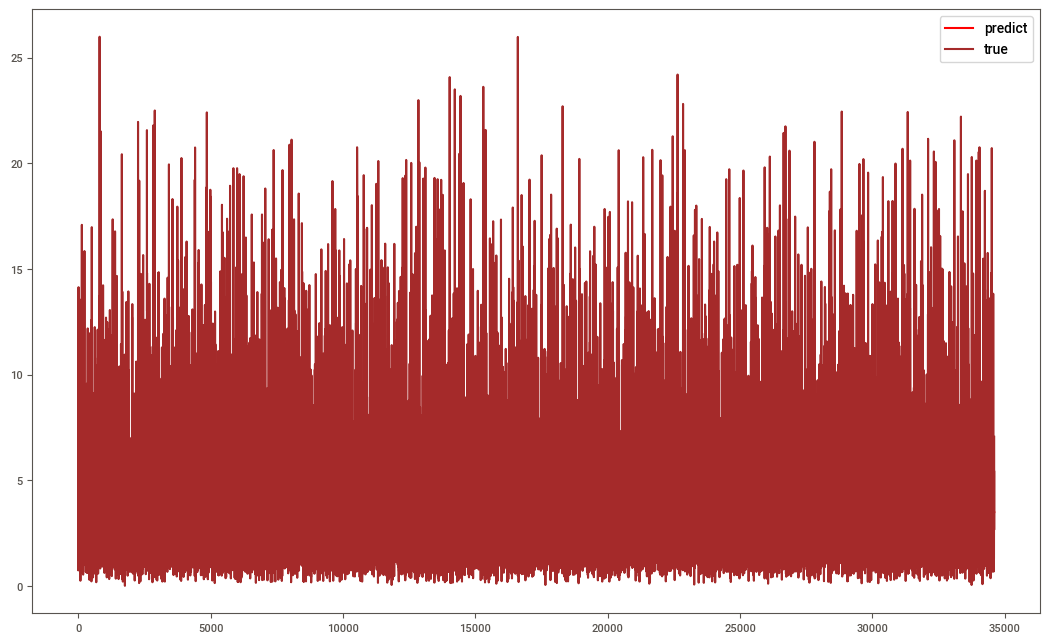

In [27]:
#mape指标（可能用得上）
def mape(test_y,predict_y):
    return np.mean(np.abs(((predict_y-test_y)/test_y)))*100

#反归一化
predict=scaler.inverse_transform(predict)
testy=scaler.inverse_transform(testy.reshape(-1,1))

#可视化
plt.figure(figsize=(13,8))  #大小，颜色都可调
plt.plot(predict,c='red',label='predict')
plt.plot(testy,c='brown',label='true')
plt.legend();

#指标衡量（MAE,RMSE,MAPE）
print('r2: %.5f' %r2_score(predict,testy))
mae = mean_absolute_error(predict,testy)
rmse = np.sqrt(mean_squared_error(predict,testy))      
print(' MAE : %.5f ' %(mae))
print(' RMSE : %.5f ' %(rmse))
print(' MAPE : %.6f ' %((mape(predict,testy))))

In [28]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras import *
import os
import seaborn as sns
import gensim
import sklearn
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Input, Dropout, Bidirectional
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import StratifiedKFold
from gensim.models import word2vec, KeyedVectors
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
#import jieba
import re
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import load_model


In [29]:
def attention_3d_block(inputs):
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, trainx.shape[1]))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(trainx.shape[1], activation='softmax')(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, mode='auto')
# model.fit(train_x, train_y, batch_size=32, epochs=5, validation_split=0.1, callbacks=[reduce_lr])
callbacks = [EarlyStopping(monitor='val_loss', verbose=1, patience=50),
			 ModelCheckpoint("model.hdf5", monitor='val_loss',
							 mode='min', verbose=0, save_best_only=True)]   


In [30]:
#定义当误差为最小时保存最优模型，patience=1111表示1111个epoch损失都没有下降那么可以提前停止
#lsym.hdf5为保存的模型名称，monitor为观测值也就是val_loss，mode='min'代表最小的val_loss
# model1 = Sequential()
inputs = Input(shape=(trainx.shape[1], trainx.shape[2]))
context1 = GRU(3, return_sequences=True)(inputs)  #lstm神经元数量为48个 激活函数为relu
# context1=tensorflow.keras.layers.Dropout(0.5)(context1)
atten = attention_3d_block(context1)
# con2=Conv1D(48, 3, padding='same')(atten )
# atten=tensorflow.keras.layers.GlobalAveragePooling1D()(con2)
atten = Flatten()(atten)
x = Dense(128, activation='relu')(atten)# 全连接层,全连接层神经元维度为48
x = Dense(128, activation='relu')(x)# 全连接层,全连接层神经元维度为48
x = Dense(128, activation='relu')(x)# 全连接层,全连接层神经元维度为48
# x = Dense(1024, activation='relu')(x)# 全连接层,全连接层神经元维度为48
output = Dense(1, activation='relu')(x)  #softmax层
model = Model(inputs=[inputs], outputs=output)
model.compile(loss='mean_squared_error', optimizer='adam',metrics =["mae"])   #损失为mse ，优化器为adam
#model.summary()

# fit network
LSTM = model.fit(trainx, trainy, epochs=300, batch_size=32, callbacks=callbacks,
                 validation_data=(X_test, y_test), verbose=1)
#callbacks为上面定义的保存最优模型用的，validation_data为验证集，verbose代表每个epoch都打印

model_new = load_model("model.hdf5")  #加载最好的模型
model_new.evaluate(testx, testy) 
model.evaluate(testx, testy)  #计算测试集的val_loss
y_pre=list(np.squeeze(model.predict(testx)))

y_pre = pd.Series(np.array(y_pre))
y_test = pd.Series(np.array(testy))


ValueError: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.series.Series'>

In [ ]:
df = pd.DataFrame({'y_pre':y_pre,'y_test':y_test})

#评价指标
def mape(test_y,predict_y):
    return np.mean(np.abs(((predict_y-test_y)/test_y)))*100

r2 = r2_score(y_pre,y_test)
rmse = np.sqrt(mean_squared_error(y_pre,y_test))
mae = mean_absolute_error(y_pre,y_test)

print(' R2 : %.5F'  %(r2))           
print(' MAE : %.5f ' %(mae))
print(' RMSE : %.5f ' %(rmse))
print(' MAPE : %.5f ' %((mape(y_pre,y_test))))

sns.set()
fig,ax = plt.subplots(figsize=(13,8))
ax.plot(y_test,c='r',label='True')
ax.plot(y_pre,c='g',label='Predict')
ax.legend()